<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import random
from IPython import display
import copy
import time
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from torchvision import transforms as tfs
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from matplotlib.offsetbox import TextArea, AnnotationBbox
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt", images_name = "lfw-deepfunneled", cropsize=110, rescale=64):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("gdown http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("gdown http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    transform = tfs.Compose([
                              tfs.CenterCrop(cropsize),
                              tfs.Resize(rescale, interpolation=tfs.InterpolationMode.BOX),
                              tfs.ToTensor(),
                            ])

    def preprocess(img):
        img = Image.open(img)
        img.load()
        return transform(img)

    all_photos =df['photo_path'].apply(preprocess)

    all_photos = torch.Tensor(np.stack(all_photos.values))#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_photos, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=50, shuffle=False)

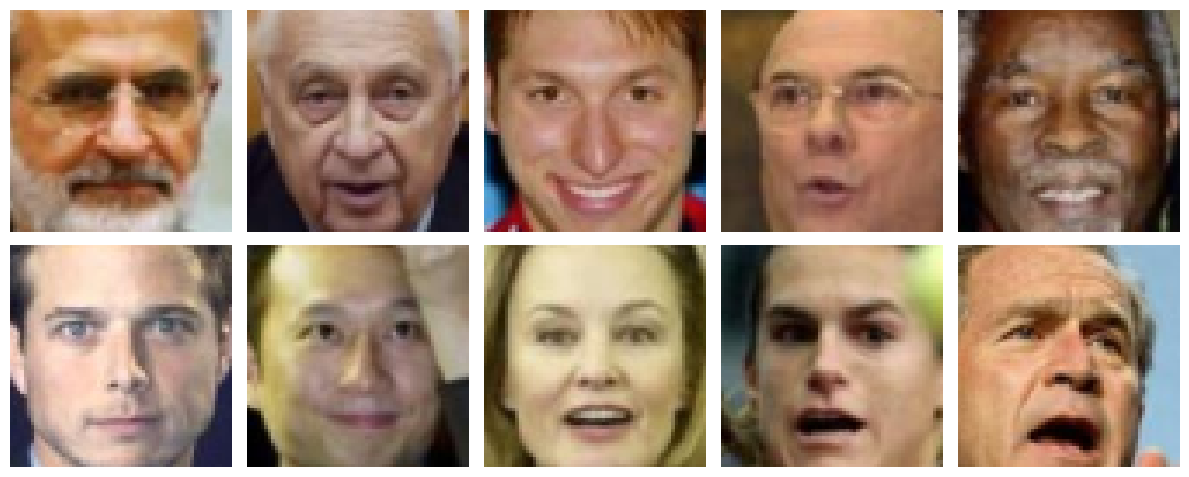

In [ ]:
# Визуализируем 10 случайных изображений из датасета
fig,ax = plt.subplots(2,5,figsize=(12,5))
axr = ax.ravel()
idxs = np.random.randint(0,len(data),10)
for i,ax in enumerate(axr):
    ax.imshow(data[idxs[i]].permute((1,2,0)))
    ax.axis('off')
plt.tight_layout()

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class LinearAE(nn.Module):
    def __init__(self, latent_dim):
        # Обратите внимание на формат, в котором функция fetch() возвращает data
        super(LinearAE,self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*64*64,self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim,3*64*64),
            nn.Unflatten(1,(3,64,64)),
            nn.Sigmoid()
        )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [ ]:
class ConvAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAE, self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=2,stride=2),
            nn.PReLU(),
            nn.Conv2d(64,128,kernel_size=2,stride=2),
            nn.PReLU(),
            nn.Flatten(),
            nn.Linear(128*16*16,self.latent_dim)

        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128*16*16),
            nn.PReLU(),
            nn.Unflatten(1,(128,16,16)),
            nn.ConvTranspose2d(128,64,kernel_size=2,stride=2),
            nn.PReLU(),
            nn.ConvTranspose2d(64,64, kernel_size=2, stride=2),
            nn.PReLU(),
            nn.Conv2d(64,3,kernel_size=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, viz=True, scheduler=None) -> pd.DataFrame:

    model.to(device)
    history = {"epoch": [], "train_loss": [], "val_loss": []}

    best_weights = model.state_dict()
    best_loss = 1e-8


    if viz:
        X_viz = next(iter(data_val))
        fig = plt.figure(figsize=(25,5), facecolor='w')
        gs0 = fig.add_gridspec(1, 2)
        gs00 = gs0[0].subgridspec(2, 5)
        gs01 = gs0[1].subgridspec(2, 5)
        for a in range(2):
            for b in range(5):
                fig.add_subplot(gs00[a, b])
        fig.add_subplot(gs01[:,:-2] );
        pbar = range(epochs)
    else:

        pbar = trange(epochs, desc='Epoch:')
    tic = time.time()
    for epoch in pbar:
        avg_train_loss = 0
        avg_val_loss = 0

        model.train()
        for X_batch in data_tr:
            X_batch = X_batch.to(device)
            opt.zero_grad()
            Y_pred,_ = model(X_batch)
            loss =  loss_fn(Y_pred, X_batch)
            loss.backward()
            opt.step()

            avg_train_loss += loss / len(data_tr)

        model.eval()
        with torch.no_grad():
            for X_val_batch in data_val:
                X_val_batch = X_val_batch.to(device)
                Y_val_pred,_ = model(X_val_batch)
                val_loss =  loss_fn(Y_val_pred, X_val_batch)
                avg_val_loss += val_loss / len(data_val)

        if avg_val_loss.cpu().item() < best_loss:
            best_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step()

        history['epoch'].append(epoch+1)
        history['train_loss'].append(avg_train_loss.cpu().item())
        history['val_loss'].append(avg_val_loss.cpu().item())

        Y_pred.cpu()
        Y_val_pred.cpu()
        avg_val_loss.cpu()
        avg_train_loss.cpu()
        X_batch.cpu(),
        X_val_batch.cpu()
        loss.cpu()
        val_loss.cpu()
        torch.cuda.empty_cache()

        model.eval()
        if not viz:
            pbar.set_description(f'train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
        else:
            Y_hat = model(X_viz.to(device))[0].detach().cpu()
            display.clear_output(wait=True)
            tempdf = pd.DataFrame(history)
            for k in range(5):
                fig.axes[k].imshow(X_viz[k].permute((1,2,0)))
                fig.axes[k].set_title('Source')
                fig.axes[k].set_axis_off()
                fig.axes[k+5].imshow(Y_hat[k].permute((1,2,0)))
                fig.axes[k+5].set_title('Reconstructed')
                fig.axes[k+5].set_axis_off()
            fig.axes[-1].plot(history['epoch'], tempdf['train_loss'], label='Train loss', color='lightblue')
            fig.axes[-1].plot(history['epoch'], tempdf['val_loss'], label='Val loss', color='orange')
            fig.axes[-1].grid(True, linestyle='--')
            fig.axes[-1].set_xlabel('Epoch')
            fig.axes[-1].set_title('Loss')
            fig.axes[-1].legend(['Train loss','Val loss'])
            fig.suptitle(f'Epoch: {(epoch+1):d}/{epochs:d} Elapsed time: {(time.time()-tic):.2f} sec\
                train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
            display.display(plt.gcf())
    if viz:
        display.clear_output(wait=True)

    model.cpu()
    model.load_state_dict(best_weights)
    torch.cuda.empty_cache()
    return pd.DataFrame(history)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

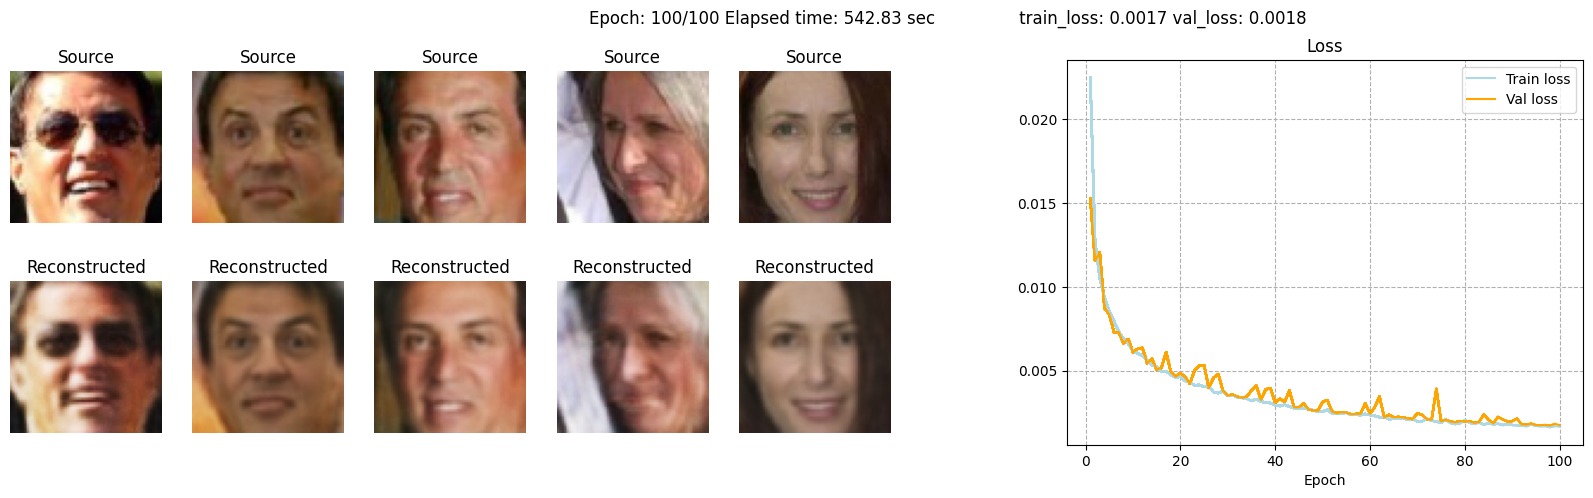

In [ ]:
criterion = nn.MSELoss()
linear_ae = LinearAE(512)
linear_ae_optimizer = torch.optim.AdamW(linear_ae.parameters(), lr=3e-4, amsgrad=True)
linear_ae_history = train(model=linear_ae, opt=linear_ae_optimizer, loss_fn=criterion, epochs=100, data_tr=train_loader, data_val=val_loader, viz=True, scheduler=None)

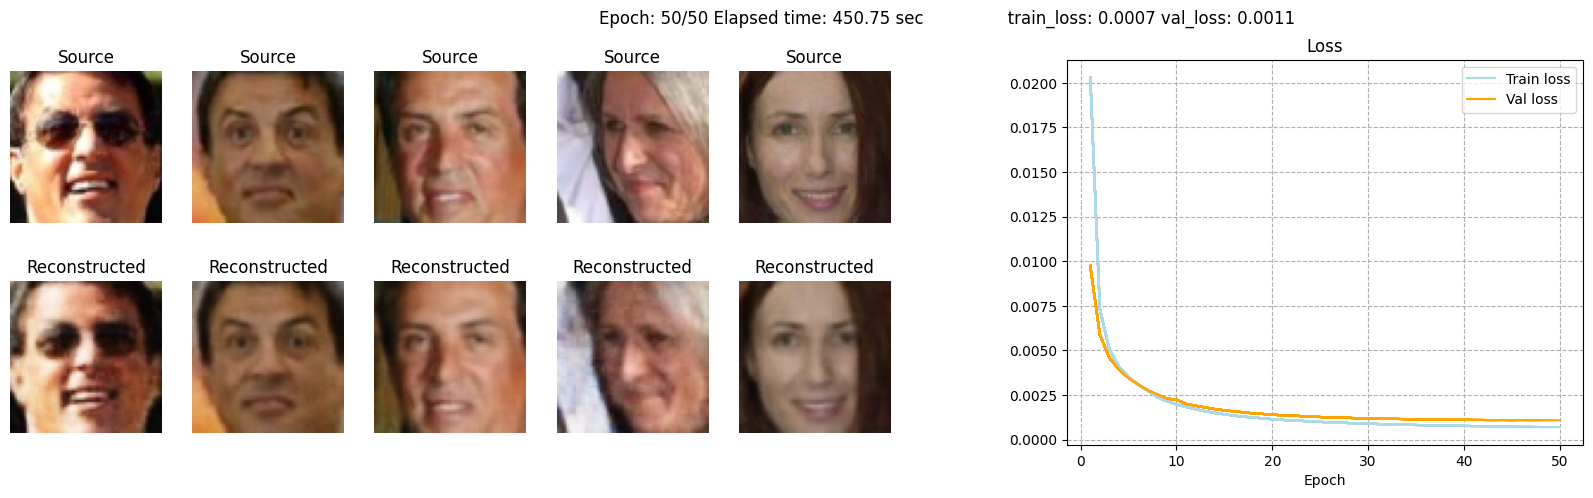

In [ ]:
criterion = nn.MSELoss()
conv_ae = ConvAE(512)
conv_ae_optimizer = torch.optim.AdamW(conv_ae.parameters(), lr=3e-4, amsgrad=True)
conv_ae_history = train(model=conv_ae, opt=conv_ae_optimizer, loss_fn=criterion, epochs=50, data_tr=train_loader, data_val=val_loader, viz=True, scheduler=None)

Not bad, right?

In [ ]:
def visualize(model, data, num_imgs):
    idxs = np.random.randint(0,len(val_photos),num_imgs)
    encoded,_ = model(data[idxs])
    fig,ax = plt.subplots(2,num_imgs, figsize=(num_imgs*2+2,5))
    for i in range(len(idxs)):
        ax[0,i].imshow(data[idxs][i].permute((1,2,0)))
        ax[0,i].set_title('Source')
        ax[0,i].axis('off')
        ax[1,i].imshow(encoded[i].detach().permute((1,2,0)))
        ax[1,i].set_title('Reconstructed')
        ax[1,i].axis('off')
    plt.tight_layout();

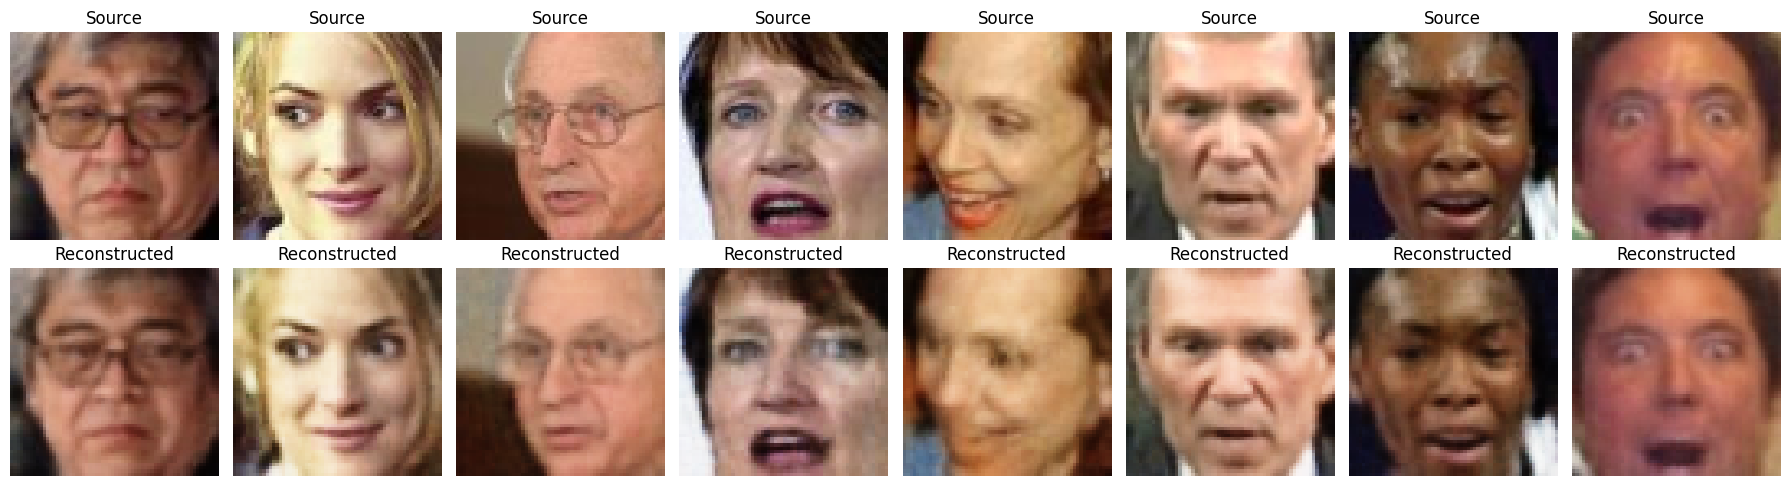

In [ ]:
visualize(conv_ae, val_photos, 8)

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
all_vecs = torch.FloatTensor()
with torch.no_grad():
    conv_ae.to(device)
    conv_ae.eval()
    for batch in train_loader:
        batch = batch.to(device)
        lat = conv_ae.encoder(batch)
        all_vecs = torch.cat((all_vecs,lat.cpu()))
        batch.cpu()
        del batch
        torch.cuda.empty_cache()
    conv_ae.cpu()

latent_mean = all_vecs.mean(axis=0)
latent_std = all_vecs.std(axis=0)

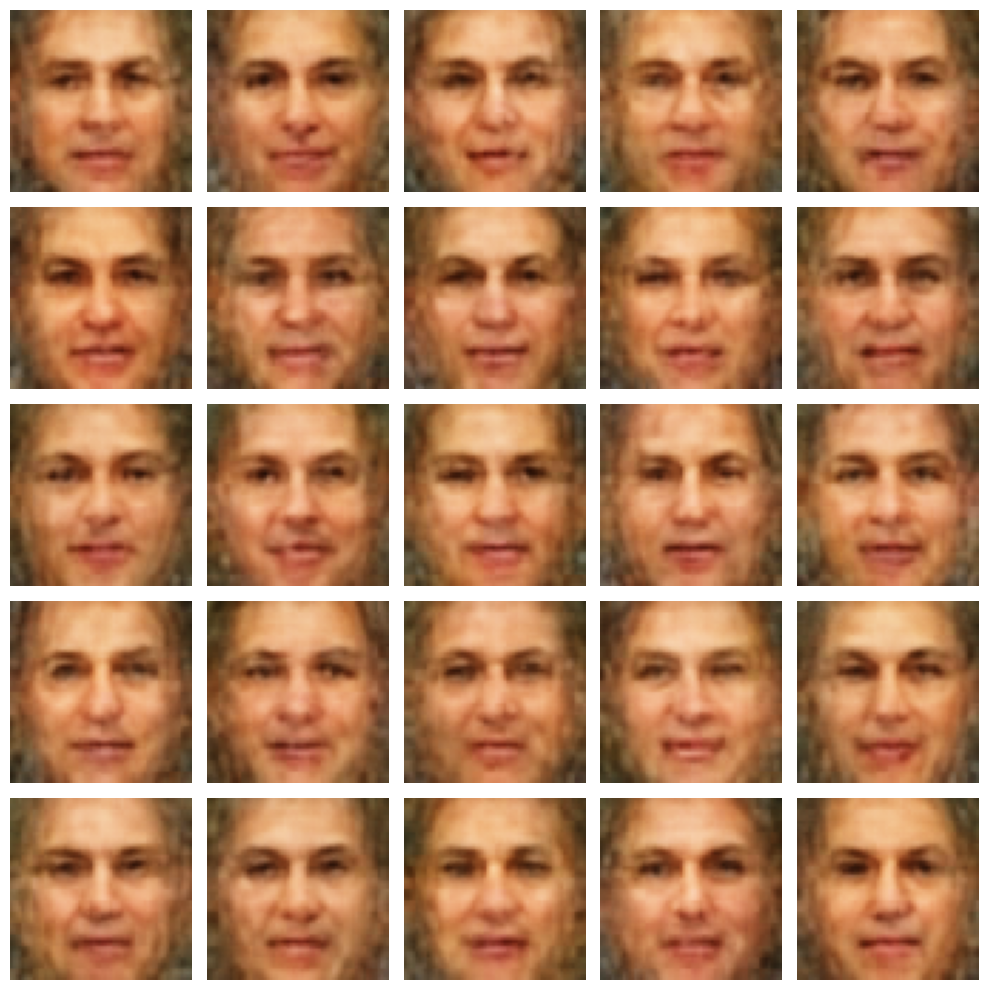

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.FloatTensor(np.random.randn(25, 512))
z = z*latent_std*.4 + latent_mean*2
output = conv_ae.decoder(torch.FloatTensor(z))
fig,ax = plt.subplots(5,5,figsize=(10,10))
axr = ax.ravel()
for i in range(len(z)):
    axr[i].imshow(output[i].detach().permute((1,2,0)))
    axr[i].axis('off')
plt.tight_layout()

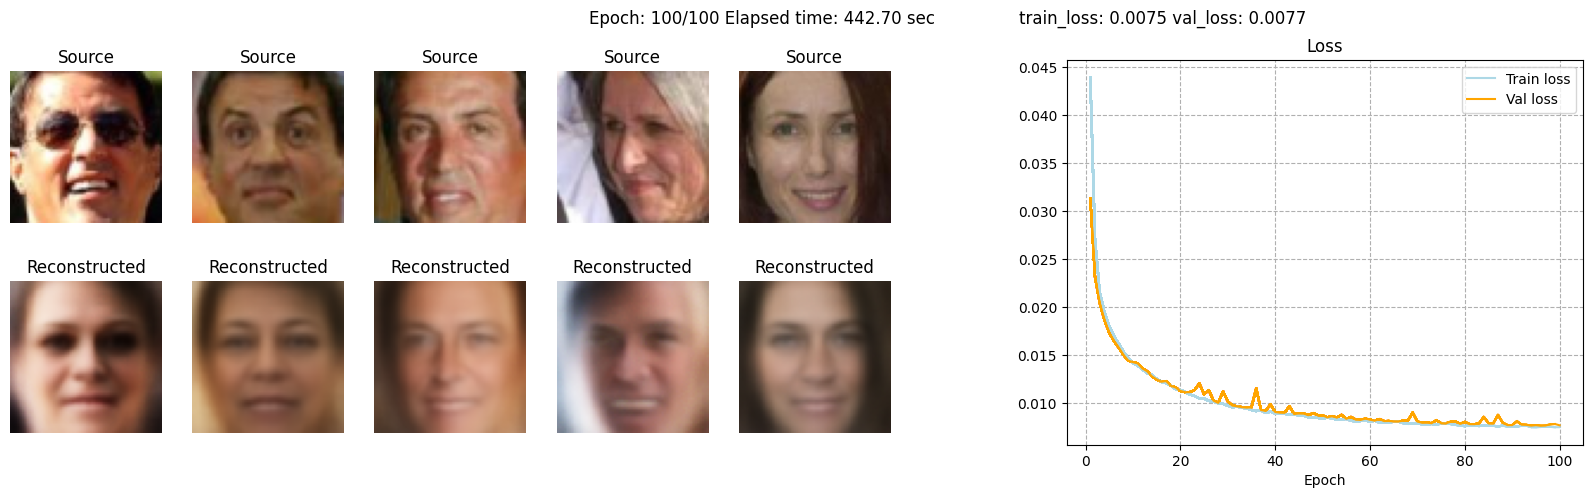

In [ ]:
criterion = nn.MSELoss()
linear_ae_32 = LinearAE(32)
linear_ae_32_optimizer = torch.optim.AdamW(linear_ae_32.parameters(), lr=3e-4, amsgrad=True)
linear_ae_32_history = train(model=linear_ae_32, opt=linear_ae_32_optimizer, loss_fn=criterion, epochs=100, data_tr=train_loader, data_val=val_loader, viz=True, scheduler=None)

In [ ]:
all_32_vecs = torch.FloatTensor()
with torch.no_grad():
    linear_ae_32.to(device)
    linear_ae_32.eval()
    for batch in train_loader:
        batch = batch.to(device)
        lat = linear_ae_32.encoder(batch)
        all_32_vecs = torch.cat((all_32_vecs,lat.cpu()))
        batch.cpu()
        del batch
        torch.cuda.empty_cache()
    linear_ae_32.cpu()

latent_32_mean = all_32_vecs.mean(axis=0)
latent_32_std = all_32_vecs.std(axis=0)

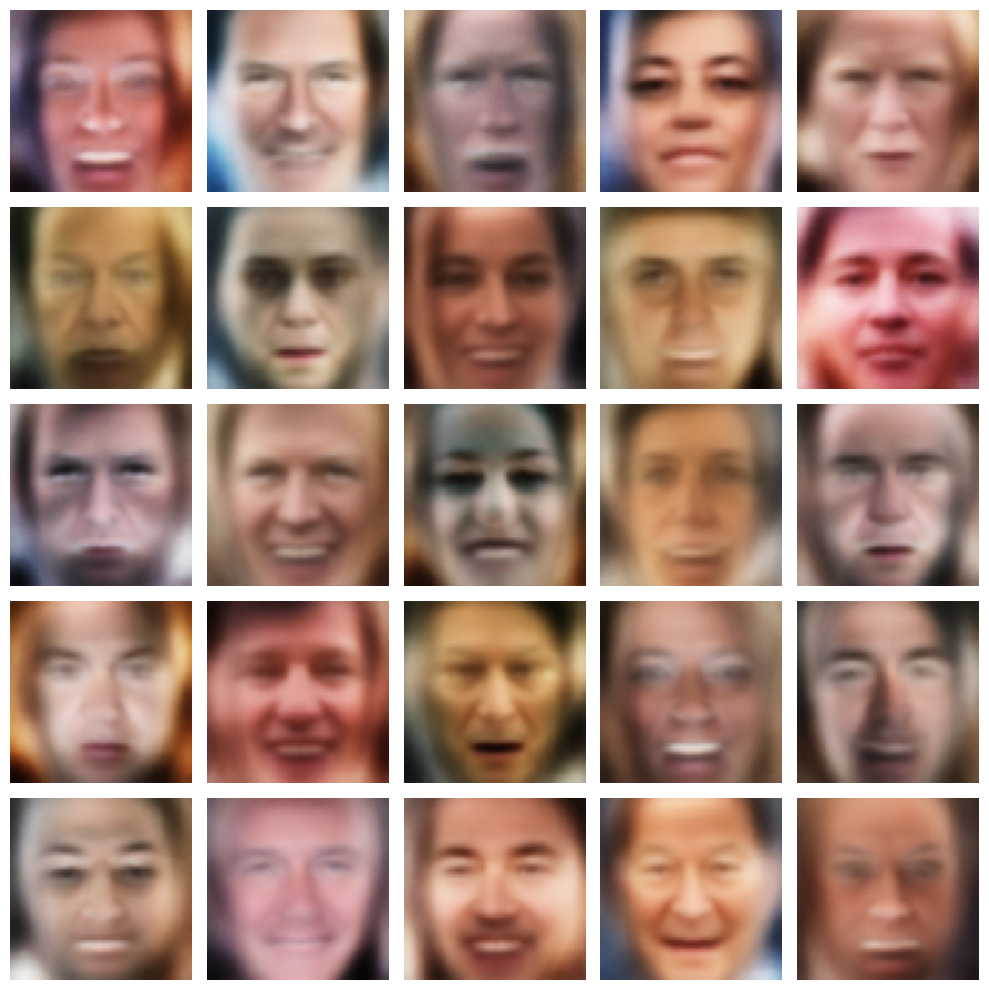

In [ ]:
z = torch.FloatTensor(np.random.randn(25, 32))
z = z*latent_32_std + latent_32_mean
output = linear_ae_32.decoder(torch.FloatTensor(z))
fig,ax = plt.subplots(5,5,figsize=(10,10))
axr = ax.ravel()
for i in range(len(z)):
    axr[i].imshow(output[i].detach().permute((1,2,0)))
    axr[i].axis('off')
plt.tight_layout()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
def get_vecs(model, data):
    model.to(device)
    model.eval()
    vecs = torch.FloatTensor()
    with torch.no_grad():
        for batch in data:
            batch = batch.to(device)
            lat = model.encoder(batch)
            vecs = torch.cat((vecs,lat.cpu()))
            batch.cpu()
            del batch
        model.cpu()
        torch.cuda.empty_cache()
    return vecs

In [ ]:
smiling_idxs = train_attrs['Smiling'].sort_values(ascending=False)[:1000].index.values
grumpy_idxs = train_attrs['Smiling'].sort_values(ascending=True)[:1000].index.values
neutral_idxs = train_attrs[(train_attrs['Smiling'] > -.2) & (train_attrs['Smiling'] < .2)]['Smiling'][:1000].index.values

smiling_loader =  torch.utils.data.DataLoader(train_photos[smiling_idxs], batch_size=50, shuffle=False)
grumpy_loader =  torch.utils.data.DataLoader(train_photos[grumpy_idxs], batch_size=50, shuffle=False)
neutral_loader =  torch.utils.data.DataLoader(train_photos[neutral_idxs], batch_size=50, shuffle=False)

smiling_mean = (get_vecs(conv_ae,smiling_loader)).mean(axis=0)
grumpy_mean = (get_vecs(conv_ae,grumpy_loader)).mean(axis=0)
neutral_mean = (get_vecs(conv_ae,neutral_loader)).mean(axis=0)

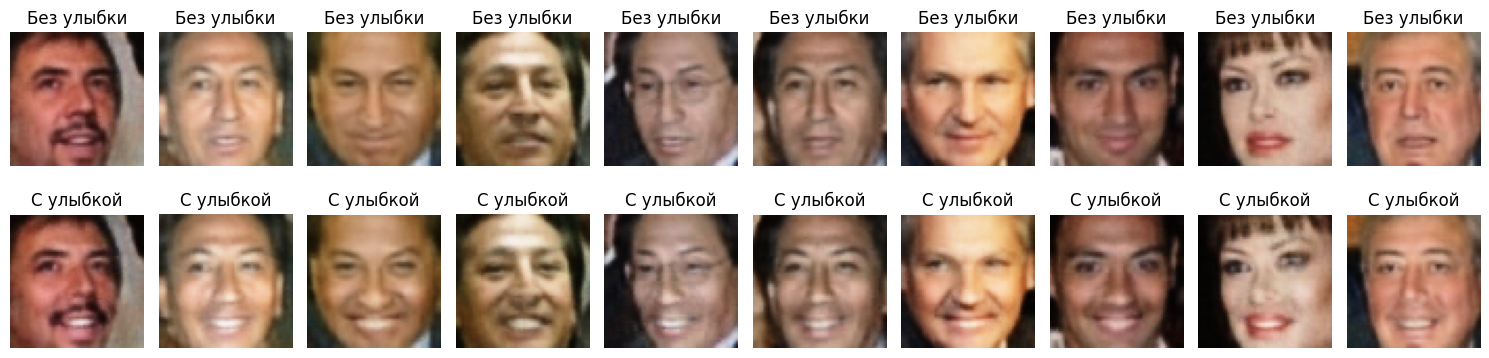

In [ ]:
smile_vector = smiling_mean-grumpy_mean

neutral_test = conv_ae.encoder(next(iter(neutral_loader)))[26:36]
neutral_plus_smile = neutral_test+smile_vector

with torch.no_grad():
    source = conv_ae.decoder(neutral_test)
    adjusted = conv_ae.decoder(neutral_plus_smile)

fig,ax = plt.subplots(2,10,figsize=(15,4))
axr = ax.ravel()
for i in range(10):
    axr[i].imshow(source[i].permute((1,2,0)))
    axr[i].axis('off')
    axr[i].set_title('Без улыбки')
    axr[i+10].imshow(adjusted[i].permute((1,2,0)))
    axr[i+10].axis('off')
    axr[i+10].set_title('С улыбкой')
plt.tight_layout()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 1000
# MNIST Dataset
vae_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=tfs.ToTensor(), download=True)
vae_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=tfs.ToTensor(), download=False)

# Data Loader (Input Pipeline)
vae_train_loader = torch.utils.data.DataLoader(dataset=vae_train_dataset, batch_size=batch_size, shuffle=True)
vae_test_loader = torch.utils.data.DataLoader(dataset=vae_test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5072100.21it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133652.37it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1267098.61it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2809812.50it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class LinearVAE(nn.Module):
    def __init__(self, latent_dim):
        super(LinearVAE,self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,self.latent_dim*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,28*28),
            nn.Unflatten(1,(1,28,28)),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1,2,self.latent_dim)
        mu = encoded[:,0,:]
        logsigma = encoded[:,1,:]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu,logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    def forward(self,x):
        out = self.block(x)
        return out

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.block = nn.Sequential(
            nn.ConvTranspose2d(self.in_channels, self.out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Conv2d(self.out_channels,self.out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU()
            )
    def forward(self, x):
        out = self.block(x)
        return out

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE,self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            DownBlock(1,64),
            DownBlock(64,128),
            nn.Flatten(),
            nn.Linear(7*7*128,self.latent_dim*2)

        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 7*7*128),
            nn.ReLU(),
            nn.Unflatten(1,(128,7,7)),
            UpBlock(128,64),
            UpBlock(64,32),
            nn.Conv2d(32,1,kernel_size=3,padding='same'),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1,2,self.latent_dim)
        mu = encoded[:,0,:]
        logsigma = encoded[:,1,:]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            return mu

    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu,logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Немного подправил функцию:

In [ ]:
def vae_train(model, opt, loss_fn, epochs, data_tr, data_val, viz=True, scheduler=None) -> pd.DataFrame:
    model.to(device)
    history = {"epoch": [], "train_loss": [], "val_loss": []}

    best_weights = model.state_dict()
    best_loss = 1e-8


    if viz:
        X_viz = next(iter(data_val))[0]
        fig = plt.figure(figsize=(25,5), facecolor='w')
        gs0 = fig.add_gridspec(1, 2)
        gs00 = gs0[0].subgridspec(2, 5)
        gs01 = gs0[1].subgridspec(2, 5)
        for a in range(2):
            for b in range(5):
                fig.add_subplot(gs00[a, b])
        fig.add_subplot(gs01[:,:-2] );

        pbar = range(epochs)
    else:
        pbar = trange(epochs, desc='Epoch:')
    tic = time.time()
    for epoch in pbar:
        avg_train_loss = 0
        avg_val_loss = 0

        model.train()
        for X_batch in data_tr:
            X_batch = X_batch[0].to(device)
            opt.zero_grad()
            mu, logsigma, reconstruction = model(X_batch)
            loss =  loss_fn(X_batch, mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            avg_train_loss += loss / len(data_tr)

        model.eval()
        with torch.no_grad():
            for X_val_batch in data_val:
                X_val_batch = X_val_batch[0].to(device)
                val_mu, val_logsigma, val_reconstruction = model(X_val_batch)
                val_loss =  loss_fn(X_val_batch, val_mu, val_logsigma, val_reconstruction)
                avg_val_loss += val_loss / len(data_val)

        if avg_val_loss.cpu().item() < best_loss:
            best_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())
        if scheduler:
            scheduler.step()

        history['epoch'].append(epoch+1)
        history['train_loss'].append(avg_train_loss.cpu().item())
        history['val_loss'].append(avg_val_loss.cpu().item())

        reconstruction.cpu()
        val_reconstruction.cpu()
        avg_val_loss.cpu()
        avg_train_loss.cpu()
        X_batch.cpu(),
        X_val_batch.cpu()
        loss.cpu()
        val_loss.cpu()
        torch.cuda.empty_cache()

        model.eval()
        if not viz:
            pbar.set_description(f'train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
        else:
            Y_hat = model(X_viz.to(device))[2].detach().cpu()
            display.clear_output(wait=True)
            tempdf = pd.DataFrame(history)
            for k in range(5):
                fig.axes[k].imshow(X_viz[k].permute((1,2,0)), cmap='gray')
                fig.axes[k].set_title('Source')
                fig.axes[k].set_axis_off()
                fig.axes[k+5].imshow(Y_hat[k].permute((1,2,0)), cmap='gray')
                fig.axes[k+5].set_title('Reconstructed')
                fig.axes[k+5].set_axis_off()
            fig.axes[-1].plot(history['epoch'], tempdf['train_loss'], label='Train loss', color='lightblue')
            fig.axes[-1].plot(history['epoch'], tempdf['val_loss'], label='Val loss', color='orange')
            fig.axes[-1].grid(True, linestyle='--')
            fig.axes[-1].set_xlabel('Epoch')
            fig.axes[-1].set_title('Loss')
            fig.axes[-1].legend(['Train loss','Val loss'])
            fig.suptitle(f'Epoch: {(epoch+1):d}/{epochs:d} Elapsed time: {(time.time()-tic):.2f} sec\
                train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
            display.display(plt.gcf())
    if viz:
        display.clear_output(wait=True)

    model.cpu()
    model.load_state_dict(best_weights)
    torch.cuda.empty_cache()
    return pd.DataFrame(history)

И обучим модель:

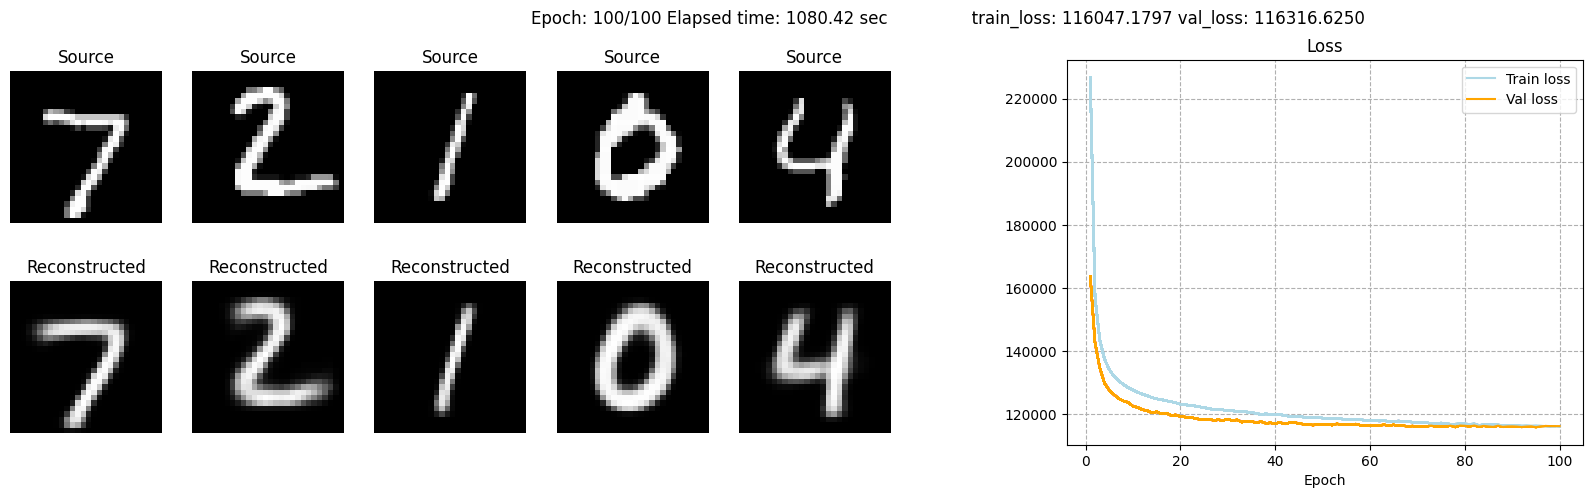

In [ ]:
criterion = loss_vae
fc_var_autoencoder = LinearVAE(4)
optimizer = torch.optim.AdamW(fc_var_autoencoder.parameters(), lr=1e-3, amsgrad=True)
fc_vae_history = vae_train(fc_var_autoencoder, optimizer, criterion, 100, vae_train_loader, vae_test_loader, viz=True, scheduler=None)

In [ ]:
def var_visualize(model, data, num_imgs):
    idxs = np.random.randint(0,len(data),num_imgs)
    _,_,encoded = model(data[idxs])
    fig,ax = plt.subplots(2,num_imgs, figsize=(num_imgs*1.3+2,4))
    for i in range(len(idxs)):
        ax[0,i].imshow(data[idxs][i].permute((1,2,0)), cmap='gray')
        ax[0,i].set_title('Source')
        ax[0,i].axis('off')
        ax[1,i].imshow(encoded[i].detach().permute((1,2,0)), cmap='gray')
        ax[1,i].set_title('Reconstructed')
        ax[1,i].axis('off')
    plt.tight_layout();

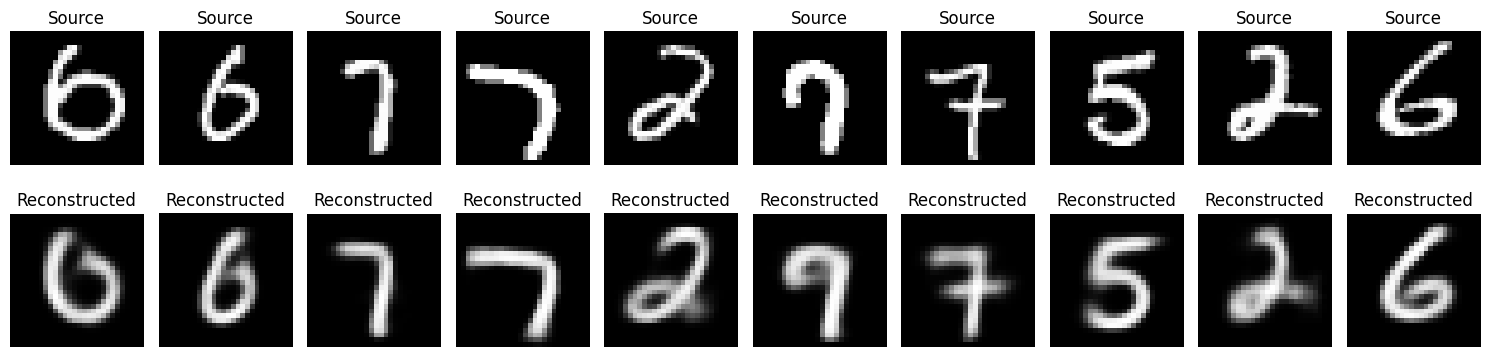

In [ ]:
var_visualize(fc_var_autoencoder, next(iter(vae_test_loader))[0], 10)

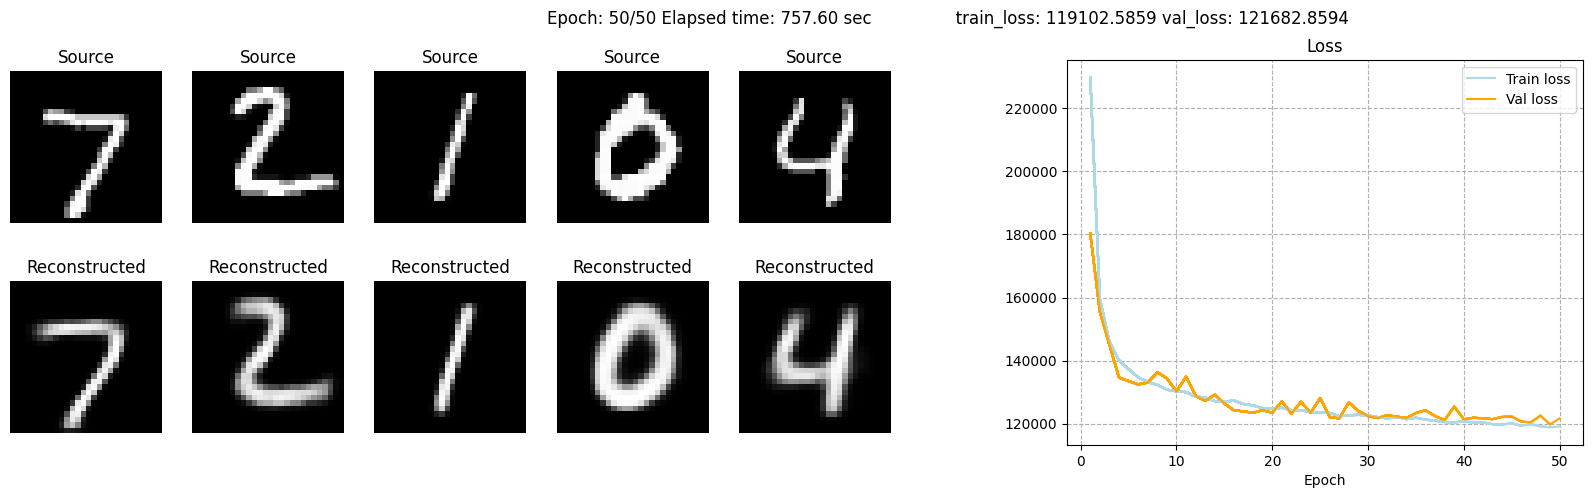

In [ ]:
criterion = loss_vae
conv_var_autoencoder = ConvVAE(4)
optimizer = torch.optim.AdamW(conv_var_autoencoder.parameters(), lr=1e-3, amsgrad=True)
conv_vae_history = vae_train(conv_var_autoencoder, optimizer, criterion, 50, vae_train_loader, vae_test_loader, viz=True, scheduler=None)

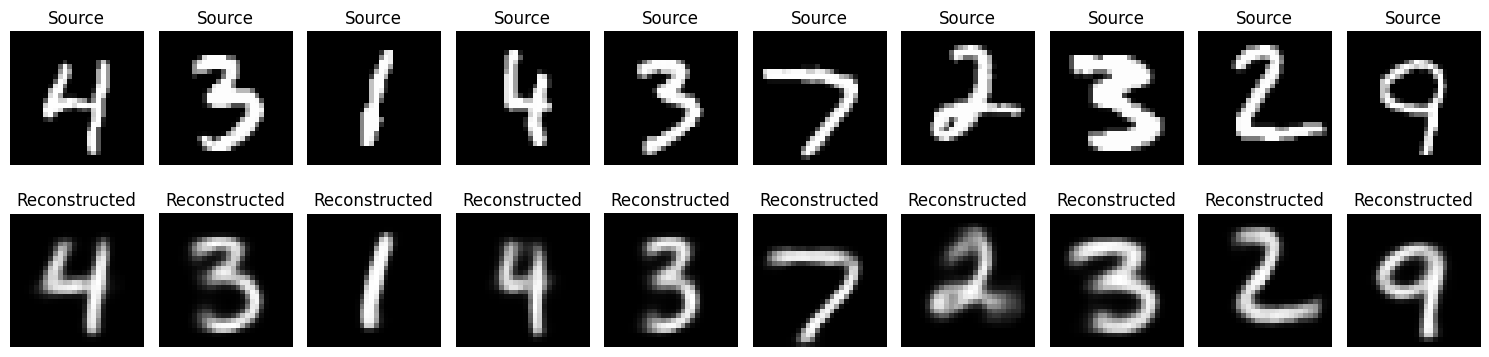

In [ ]:
var_visualize(conv_var_autoencoder, next(iter(vae_test_loader))[0], 10)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

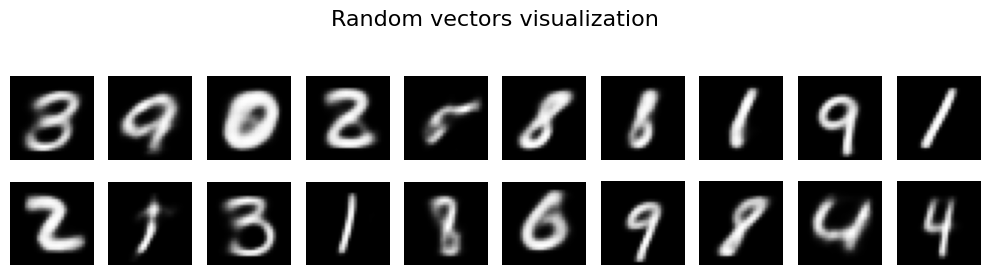

In [ ]:
z = torch.FloatTensor(np.array([np.random.normal(0, 1, 4) for i in range(20)]))
output = fc_var_autoencoder.decoder(z).detach()
fig,ax = plt.subplots(2,10,figsize=(10,3))
axr = ax.ravel()
for i in range(20):
    axr[i].imshow(output[i].permute((1,2,0)), cmap='gray')
    axr[i].axis('off')
plt.suptitle('Random vectors visualization', fontsize=16)
plt.tight_layout()

In [ ]:
criterion_2d = loss_vae
var_autoencoder_2d =ConvVAE(2)
optimizer_2d = torch.optim.AdamW(var_autoencoder_2d.parameters(), lr=1e-3, amsgrad=True)
vae_2d_history = vae_train(var_autoencoder_2d, optimizer_2d, criterion_2d, 50, vae_train_loader, vae_test_loader, viz=False, scheduler=None)

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

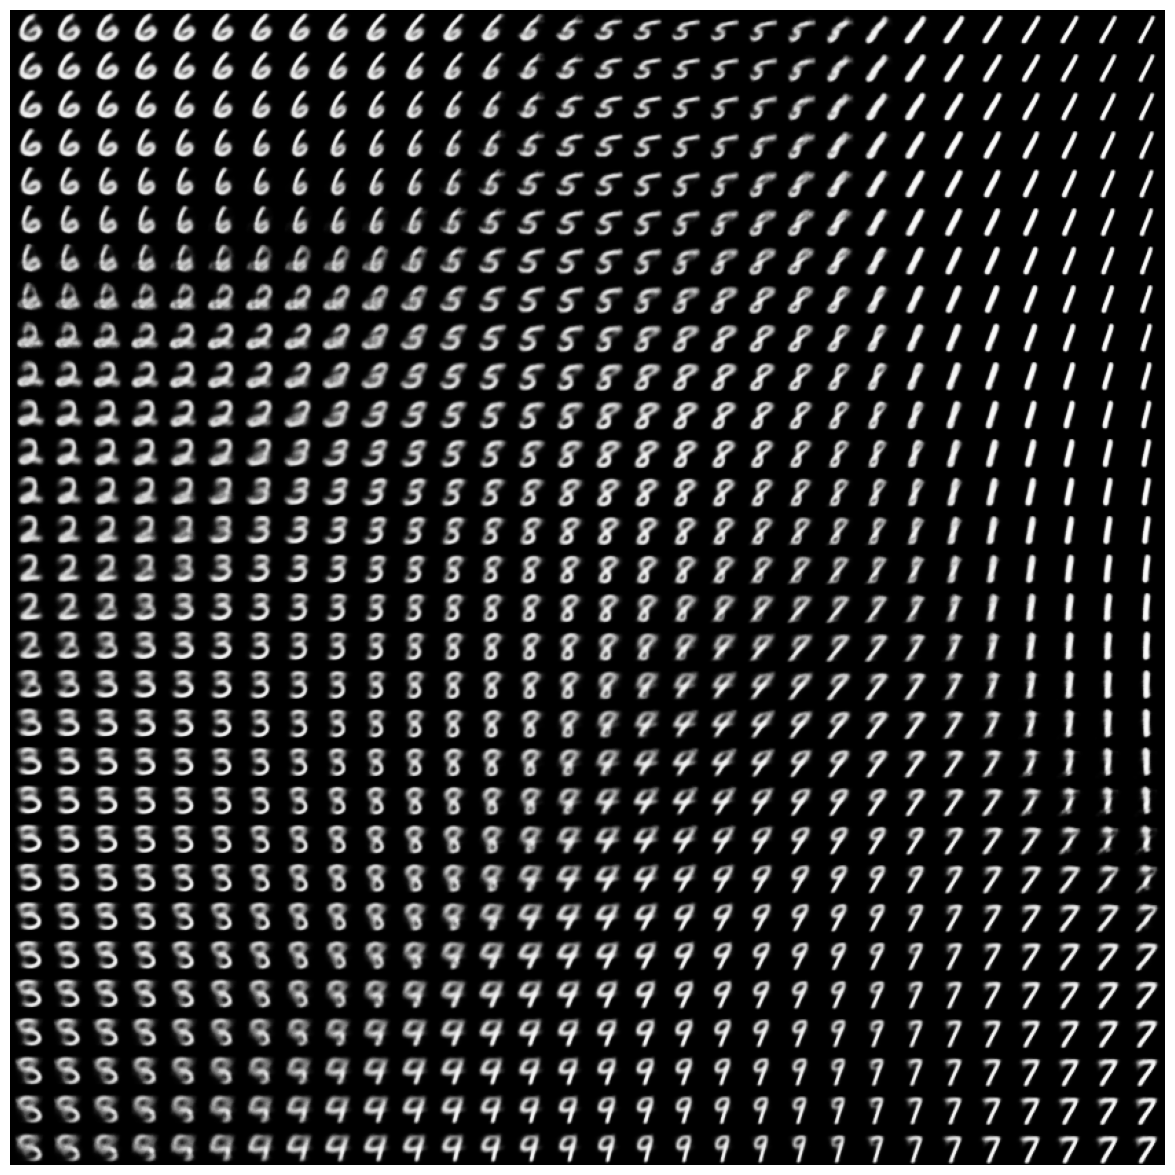

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.5
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.FloatTensor(np.array([[xi, yi]]))
            x_decoded = vae.decoder(z_sample).detach()
            digit = x_decoded.view(-1,digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    plt.axis('off')
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
plot_latent_space(var_autoencoder_2d)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
def vae_get_vectors(model,data):
    vectors = torch.FloatTensor()
    model.eval()
    with torch.no_grad():
        for batch in data:
            imgs = batch[0]
            vecs,_ = model.encode(imgs)
            vectors = torch.cat((vectors,vecs))
    return vectors

In [ ]:
fc_vae_vecs = vae_get_vectors(fc_var_autoencoder, vae_test_loader)
conv_vae_vecs = vae_get_vectors(conv_var_autoencoder, vae_test_loader)

test_labels = torch.FloatTensor([x[1] for x in vae_test_dataset])

In [ ]:
tsne = TSNE(2, random_state=SEED, n_jobs=-1)
fc_reduction = tsne.fit_transform(fc_vae_vecs.numpy())
conv_reduction = tsne.fit_transform(conv_vae_vecs.numpy())

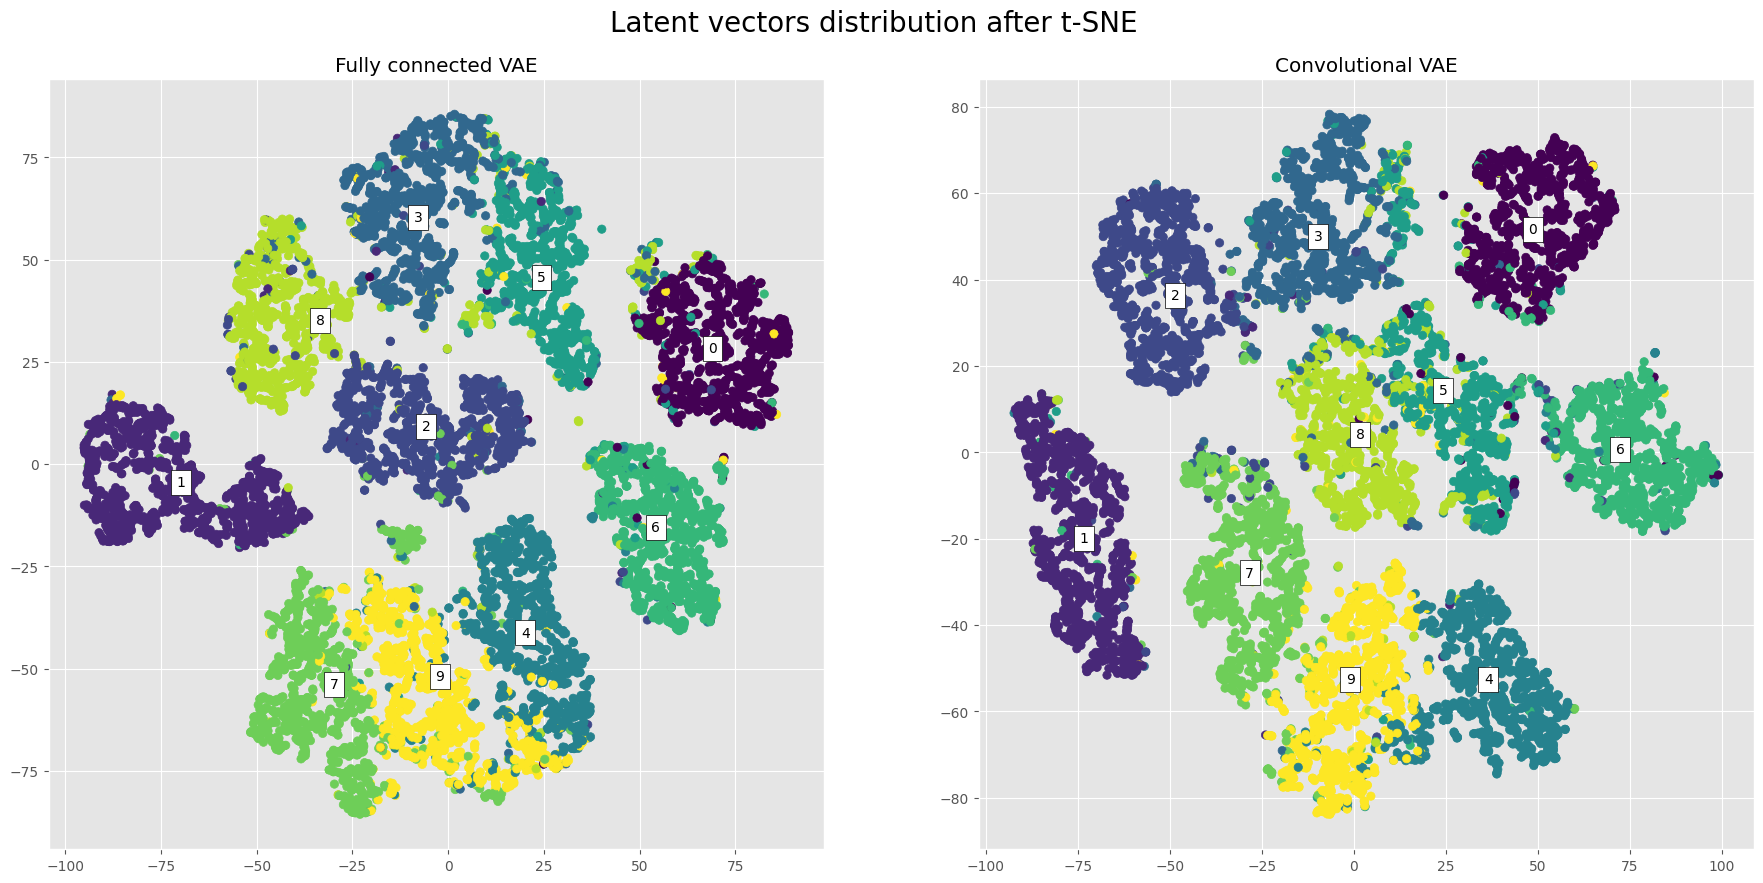

In [ ]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,2, figsize=(22,10))
    ax[0].scatter(fc_reduction[:,0], fc_reduction[:,1], c=test_labels.numpy())
    ax[0].set_title('Fully connected VAE')
    ax[1].scatter(conv_reduction[:,0], conv_reduction[:,1], c=test_labels.numpy())
    ax[1].set_title('Convolutional VAE')
    for i in range(10):
                fc_class_center =  np.mean(fc_reduction[test_labels.numpy() == i], axis=0)
                conv_class_center = np.mean(conv_reduction[test_labels.numpy() == i], axis=0)
                text = TextArea(f'{i}')
                fc_ab = AnnotationBbox(text, fc_class_center, xycoords='data', frameon=True)
                conv_ab = AnnotationBbox(text, conv_class_center, xycoords='data', frameon=True)
                ax[0].add_artist(fc_ab)
                ax[1].add_artist(conv_ab)
    plt.suptitle('Latent vectors distribution after t-SNE', fontsize=20, y=0.95)

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

* В целом распределение компактное. Как в лекциях в обяснении про KL-дивергенцию. Всё вместе собрано нормальную компактную область [-80,80] по х и по y.
* Отдельные классы(цифры) так же собраны с компактные кластеры. Кластеры между собой разделимы.
* Более плотно лежат кластеры 4,7,9 и 5,3,8 и это логично. Цифры похожи, разделить их сложнее.
* Свёрточный VAE (в моём случае, может быть я не самую удачную архитектуру выбрал) обучился хуже, хорошо видно, что 3,8,5 он разделяет хуже чем полносвязный VAE.

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(794, 512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Linear(512,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Linear(256,128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Linear(128,64),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    nn.Linear(64,self.latent_dim*2)
                )

        self.decoder = nn.Sequential(
                    nn.Linear(self.latent_dim+10, 64),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    nn.Linear(64,128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Linear(128,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Linear(256,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,28*28),
                    nn.Unflatten(1,(1,28,28)),
                    nn.Sigmoid()
                )

    def encode(self, x, class_num):
        x = torch.cat((x.flatten(1),class_num), axis=-1)
        encoded = self.encoder(x)
        encoded = encoded.view(-1,2,self.latent_dim)
        mu = encoded[:,0,:]
        logsigma = encoded[:,1,:]
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        z = torch.cat((z,class_num), axis=-1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, label):
        mu, logsigma, class_num = self.encode(x,label)
        z = self.gaussian_sampler(mu,logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [ ]:
def cvae_train(model, opt, loss_fn, epochs, data_tr, data_val, viz=True, scheduler=None) -> pd.DataFrame:

    model.to(device)
    history = {"epoch": [], "train_loss": [], "val_loss": []}

    best_weights = model.state_dict()
    best_loss = 1e-8


    if viz:
        X_viz = next(iter(data_val))
        X_viz_batch = X_viz[0]
        X_viz_label = X_viz[1]
        fig = plt.figure(figsize=(25,5), facecolor='w')
        gs0 = fig.add_gridspec(1, 2)
        gs00 = gs0[0].subgridspec(2, 5)
        gs01 = gs0[1].subgridspec(2, 5)
        for a in range(2):
            for b in range(5):
                fig.add_subplot(gs00[a, b])
        fig.add_subplot(gs01[:,:-2] );
        pbar = range(epochs)
    else:
        pbar = trange(epochs, desc='Epoch:')
    tic = time.time()
    for epoch in pbar:
        avg_train_loss = 0
        avg_val_loss = 0

        model.train()
        for X_batch in data_tr:
            X_batch_label = torch.nn.functional.one_hot(X_batch[1], num_classes=10).to(device)
            X_batch = X_batch[0].to(device)
            opt.zero_grad()
            mu, logsigma, reconstruction = model(X_batch, X_batch_label)
            loss =  loss_fn(X_batch, mu, logsigma, reconstruction)
            loss.backward()
            opt.step()
            avg_train_loss += loss / len(data_tr)

        model.eval()
        with torch.no_grad():
            for X_val_batch in data_val:
                X_val_batch_label = torch.nn.functional.one_hot(X_val_batch[1], num_classes=10).to(device)
                X_val_batch = X_val_batch[0].to(device)
                val_mu, val_logsigma, val_reconstruction = model(X_val_batch, X_val_batch_label)
                val_loss =  loss_fn(X_val_batch, val_mu, val_logsigma, val_reconstruction) # forward-pass
                avg_val_loss += val_loss / len(data_val)

        if avg_val_loss.cpu().item() < best_loss:
            best_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())
        if scheduler:
            scheduler.step()

        history['epoch'].append(epoch+1)
        history['train_loss'].append(avg_train_loss.cpu().item())
        history['val_loss'].append(avg_val_loss.cpu().item())

        reconstruction.cpu()
        val_reconstruction.cpu()
        avg_val_loss.cpu()
        avg_train_loss.cpu()
        X_batch.cpu(),
        X_batch_label.cpu(),
        X_val_batch.cpu()
        X_val_batch_label.cpu(),
        loss.cpu()
        val_loss.cpu()
        torch.cuda.empty_cache()

        model.eval()
        if not viz:
            pbar.set_description(f'train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
        else:
            Y_hat = model(X_viz_batch.to(device), torch.nn.functional.one_hot(X_viz_label, num_classes=10).to(device))[2].detach().cpu()# Скидываем предикт на cpu
            display.clear_output(wait=True)
            tempdf = pd.DataFrame(history)
            for k in range(5):
                fig.axes[k].imshow(X_viz[0][k].permute((1,2,0)), cmap='gray')
                fig.axes[k].set_title('Source')
                fig.axes[k].set_axis_off()
                fig.axes[k+5].imshow(Y_hat[k].permute((1,2,0)), cmap='gray')
                fig.axes[k+5].set_title('Reconstructed')
                fig.axes[k+5].set_axis_off()
            fig.axes[-1].plot(history['epoch'], tempdf['train_loss'], label='Train loss', color='lightblue')
            fig.axes[-1].plot(history['epoch'], tempdf['val_loss'], label='Val loss', color='orange')
            fig.axes[-1].grid(True, linestyle='--')
            fig.axes[-1].set_xlabel('Epoch')
            fig.axes[-1].set_title('Loss')
            fig.axes[-1].legend(['Train loss','Val loss'])
            fig.suptitle(f'Epoch: {(epoch+1):d}/{epochs:d} Elapsed time: {(time.time()-tic):.2f} sec\
                train_loss: {avg_train_loss.item():.4f} val_loss: {avg_val_loss.item():.4f}')
            display.display(plt.gcf())
    if viz:
        display.clear_output(wait=True)

    model.cpu()
    model.load_state_dict(best_weights)
    torch.cuda.empty_cache()
    return pd.DataFrame(history)

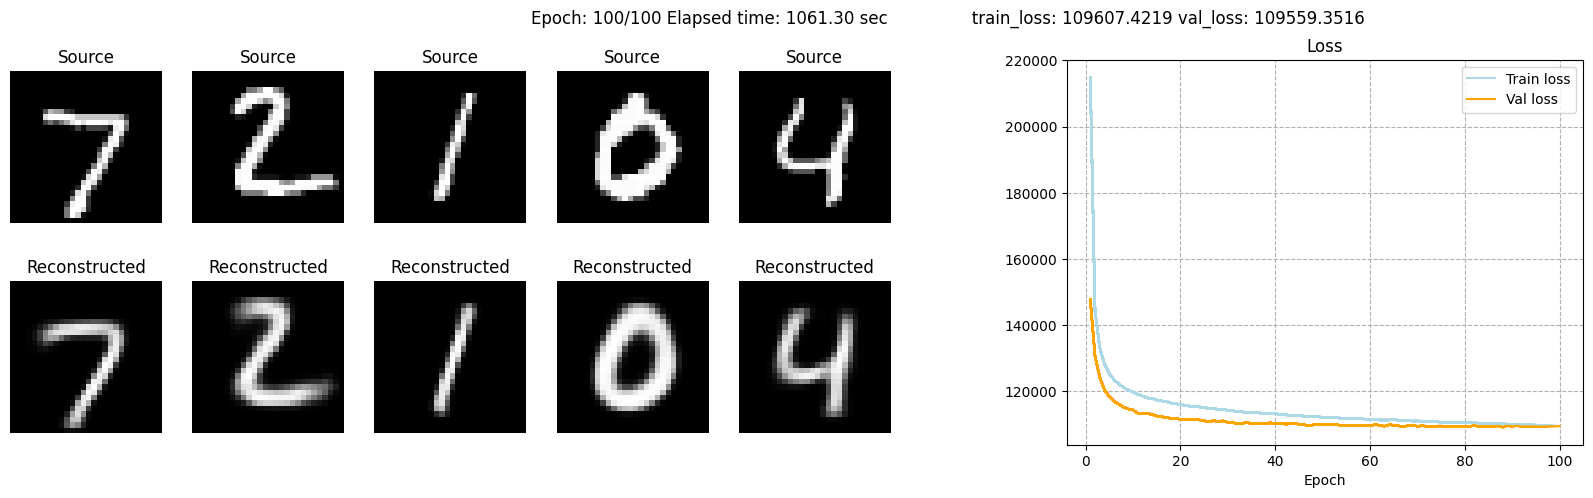

In [ ]:
cvae = CVAE(4)
optimizer = torch.optim.AdamW(cvae.parameters(), lr=1e-3, amsgrad=True)
criterion = loss_vae

cvae_history = cvae_train(cvae, optimizer, criterion, 100, vae_train_loader, vae_test_loader, viz=True, scheduler=None)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

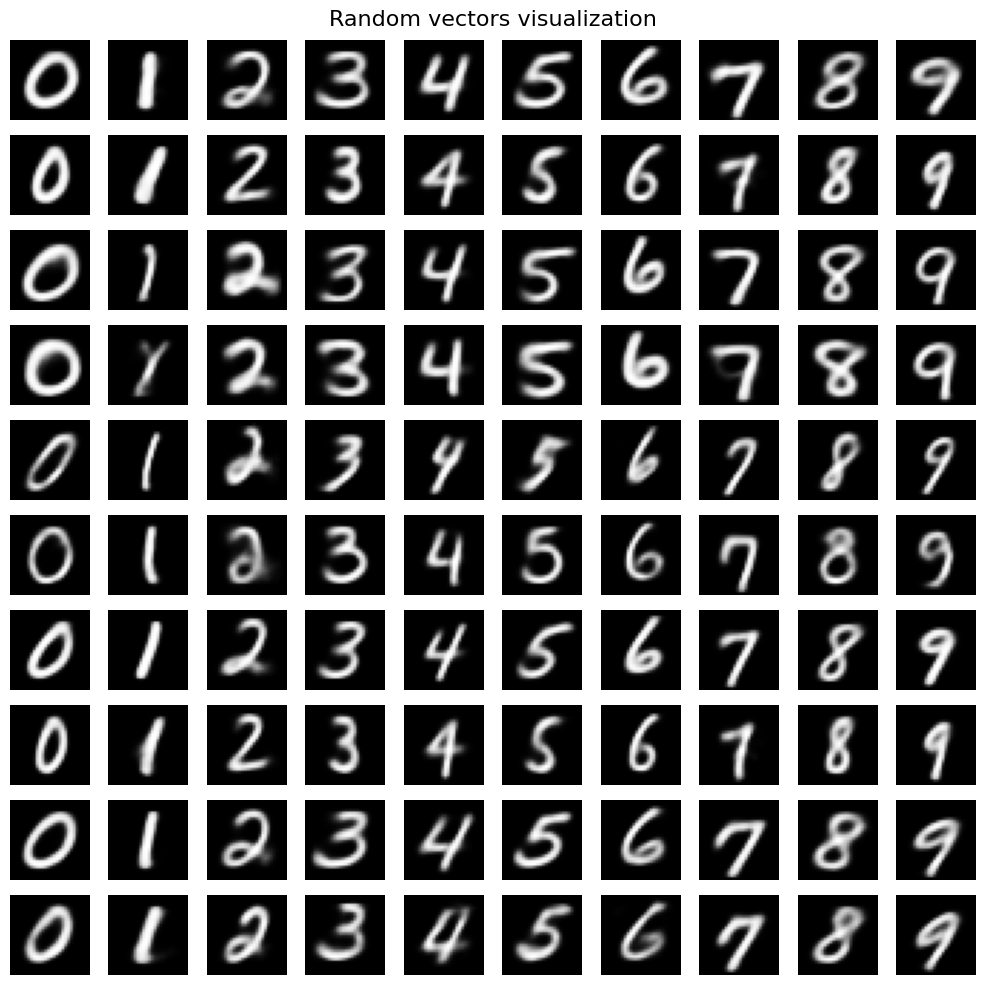

In [ ]:
z = torch.vstack([torch.randn(4).repeat(10,1) for _ in range(10)])
cls = torch.nn.functional.one_hot(torch.LongTensor(np.arange(10)), num_classes=10).repeat(10,1)
output = cvae.decode(z*1.1, cls).detach()
fig,ax = plt.subplots(10,10,figsize=(10,10))
axr = ax.ravel()
for i in range(100):
    axr[i].imshow(output[i].permute((1,2,0)), cmap='gray')
    axr[i].axis('off')
plt.suptitle('Random vectors visualization', fontsize=16)
plt.tight_layout()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
def cvae_get_vectors(model,data):
    vectors = torch.FloatTensor()
    labels = torch.FloatTensor()
    model.eval()
    with torch.no_grad():
        for batch in data:
            imgs = batch[0]
            lbls = batch[1]
            vecs,_,_ = model.encode(imgs, torch.nn.functional.one_hot(lbls,num_classes=10))
            vectors = torch.cat((vectors,vecs))
    return vectors

In [ ]:
cvae_vecs = cvae_get_vectors(cvae,vae_test_loader)
tsne = TSNE(2, random_state=SEED, n_jobs=-1)
cvae_reduction = tsne.fit_transform(cvae_vecs.numpy())

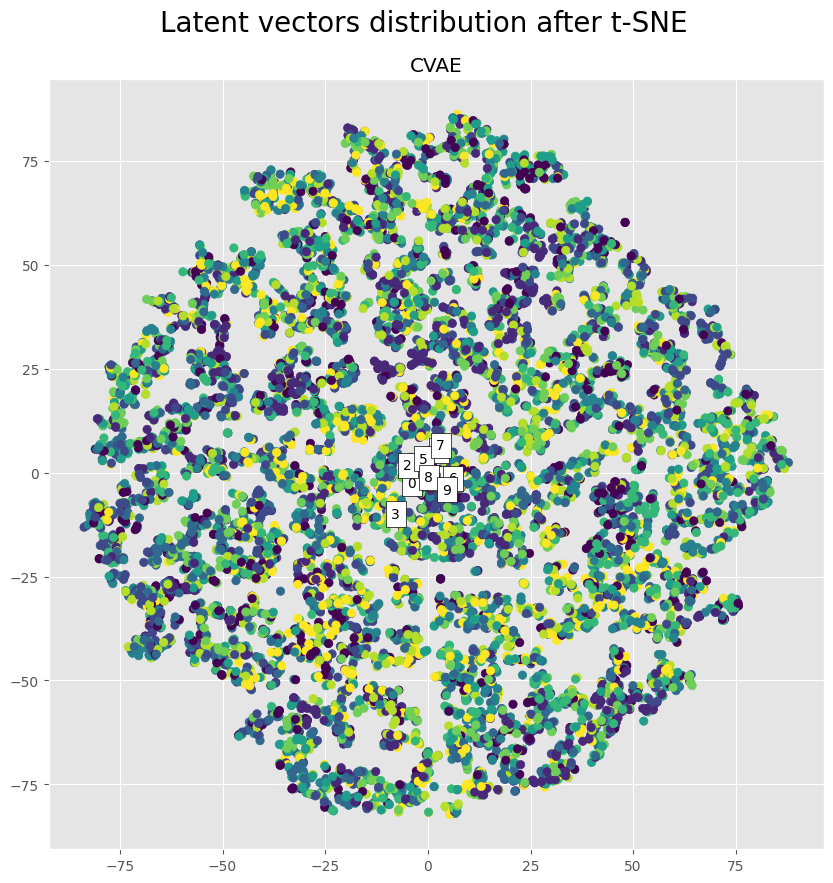

In [ ]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(cvae_reduction[:,0], cvae_reduction[:,1], c=test_labels.numpy())
    ax.set_title('CVAE')
    for i in range(10):
                cvae_class_center =  np.mean(cvae_reduction[test_labels.numpy() == i], axis=0)
                text = TextArea(f'{i}')
                cvae_ab = AnnotationBbox(text, cvae_class_center, xycoords='data', frameon=True)
                ax.add_artist(cvae_ab)
    plt.suptitle('Latent vectors distribution after t-SNE', fontsize=20, y=0.95)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Векторы распределены нормально. Центры у классов расположены очень близко.
Но теперь уже не классы кластеризуются, а похоже что именно стили. Поэтому и сэмплировать гораздо проще из такого распределения.
Плюс можно ещё и сэмплировать так, что получим стили, которых не было в обучающей выборке. Таким образом можно новую стилистику генерить.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>